# PREDICTING OUTCOME OF HORSES WITH COLIC

Three model types are being compared to best predict the outcome of horses with colic: logistic regression, k-nearest neighbors classifier, and random forest classifier. The target variable here has three classes: died, euthanized, or lived. 

## Import Packages and Read In Data

In [1]:
# Import all packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
#Read in data
horse_df = pd.read_csv('horse.csv')

## Explore Data

In [3]:
print(horse_df.head())
print(horse_df.describe())
print(horse_df.info())
nRow, nCol = horse_df.shape
print(f'There are {nRow} rows and {nCol} columns')

  surgery    age  hospital_number  rectal_temp  pulse  respiratory_rate  \
0      no  adult           530101         38.5   66.0              28.0   
1     yes  adult           534817         39.2   88.0              20.0   
2      no  adult           530334         38.3   40.0              24.0   
3     yes  young          5290409         39.1  164.0              84.0   
4      no  adult           530255         37.3  104.0              35.0   

  temp_of_extremities peripheral_pulse mucous_membrane capillary_refill_time  \
0                cool          reduced             NaN            more_3_sec   
1                 NaN              NaN   pale_cyanotic            less_3_sec   
2              normal           normal       pale_pink            less_3_sec   
3                cold           normal   dark_cyanotic            more_3_sec   
4                 NaN              NaN   dark_cyanotic            more_3_sec   

   ... packed_cell_volume total_protein abdomo_appearance abdomo_pro

## Encode and Divide Data Into Features and Target

In [4]:
#Encode taget variable as numeric
ord_enc = OrdinalEncoder()
horse_df["target"] = ord_enc.fit_transform(horse_df[["outcome"]])
horse_df[["outcome", "target"]].head(10)

,outcome,target
0,died,0.0
1,euthanized,1.0
2,lived,2.0
3,died,0.0
4,died,0.0
5,lived,2.0
6,lived,2.0
7,died,0.0
8,euthanized,1.0
9,lived,2.0


In [5]:
#Separate into features and target
X=horse_df.drop(["outcome", "target"],axis=1)
y=horse_df.target

## Clean Data

surgery                    0
age                        0
rectal_temp               60
pulse                     24
respiratory_rate          58
temp_of_extremities       56
peripheral_pulse          69
mucous_membrane           47
capillary_refill_time     32
pain                      55
peristalsis               44
abdominal_distention      56
nasogastric_tube         104
nasogastric_reflux       106
nasogastric_reflux_ph    246
rectal_exam_feces        102
abdomen                  118
packed_cell_volume        29
total_protein             33
abdomo_appearance        165
abdomo_protein           198
surgical_lesion            0
lesion_1                   0
lesion_2                   0
lesion_3                   0
cp_data                    0
dtype: int64


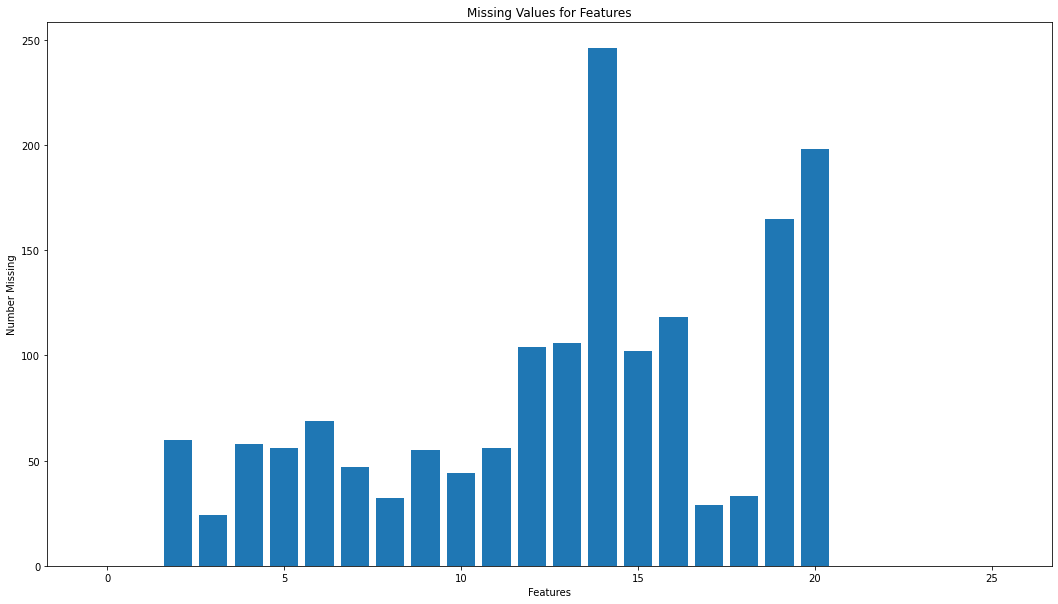

In [6]:
#Delete hospital number as feature
X.drop(['hospital_number'], axis=1, inplace=True)
#Check for null values in features and plot
null=X.isnull().sum()
print(null)
plt.figure(figsize=(18,10))
plt.bar(range(len(null)), null)
plt.title('Missing Values for Features')
plt.xlabel('Features')
plt.ylabel('Number Missing')
plt.show()

In [7]:
#Removing columns with more than 50% missing values and replacing rest of missing values with median or mode
for col in X.columns.values:
    
    if (pd.isna(X[col]).sum()) > 0: 
    
        if pd.isna(X[col]).sum() > (50/100 * len(X)): 
            print(col,"has been removed") 
            X = X.drop([col], axis=1) 
        
        elif (X[col].dtype == 'object'):
            X[col] = X[col].fillna(X[col].mode()[0])        
        
        else:
            X[col] = X[col].fillna(X[col].median())
            
                
print(X.shape)
print(X.isna().sum())

nasogastric_reflux_ph has been removed
abdomo_appearance has been removed
abdomo_protein has been removed
(299, 23)
surgery                  0
age                      0
rectal_temp              0
pulse                    0
respiratory_rate         0
temp_of_extremities      0
peripheral_pulse         0
mucous_membrane          0
capillary_refill_time    0
pain                     0
peristalsis              0
abdominal_distention     0
nasogastric_tube         0
nasogastric_reflux       0
rectal_exam_feces        0
abdomen                  0
packed_cell_volume       0
total_protein            0
surgical_lesion          0
lesion_1                 0
lesion_2                 0
lesion_3                 0
cp_data                  0
dtype: int64


## EDA

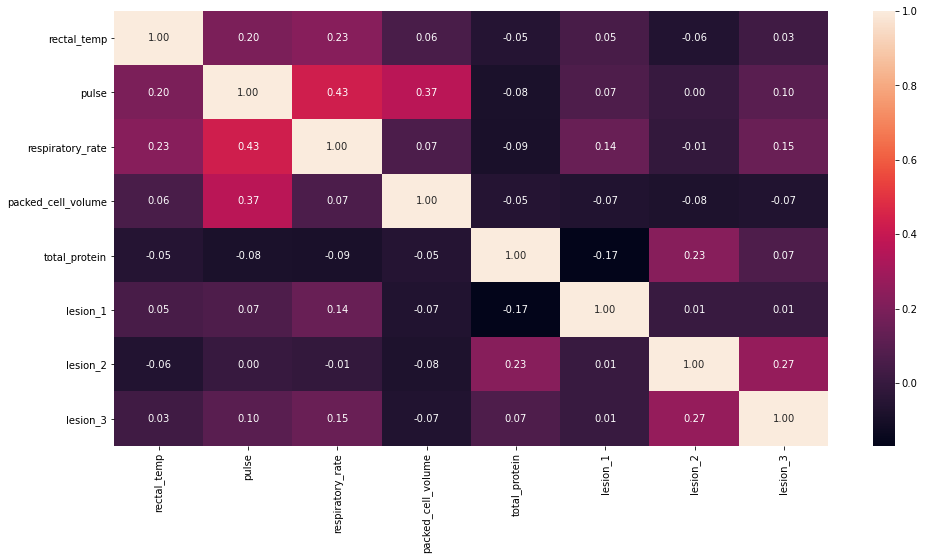

In [8]:
# Check for correlations between features
corr =X.corr()
fig, ax =plt.subplots(figsize =(16,8))
ax  = sns.heatmap(corr,annot =True,fmt = ".2f")

In [9]:
# Converting categorial data do numeric - One Hot Encoding
X = pd.get_dummies(X)
X.head(10)

,rectal_temp,pulse,respiratory_rate,packed_cell_volume,total_protein,lesion_1,lesion_2,lesion_3,surgery_no,surgery_yes,...,rectal_exam_feces_normal,abdomen_distend_large,abdomen_distend_small,abdomen_firm,abdomen_normal,abdomen_other,surgical_lesion_no,surgical_lesion_yes,cp_data_no,cp_data_yes
0,38.5,66.0,28.0,45.0,8.4,11300,0,0,1,0,...,0,1,0,0,0,0,1,0,1,0
1,39.2,88.0,20.0,50.0,85.0,2208,0,0,0,1,...,0,0,0,0,0,1,1,0,1,0
2,38.3,40.0,24.0,33.0,6.7,0,0,0,1,0,...,1,0,0,0,1,0,1,0,0,1
3,39.1,164.0,84.0,48.0,7.2,2208,0,0,0,1,...,0,1,0,0,0,0,0,1,0,1
4,37.3,104.0,35.0,74.0,7.4,4300,0,0,1,0,...,0,1,0,0,0,0,1,0,1,0
5,38.2,64.0,25.0,45.0,7.5,0,0,0,1,0,...,0,0,0,1,0,0,1,0,1,0
6,37.9,48.0,16.0,37.0,7.0,3124,0,0,0,1,...,0,1,0,0,0,0,0,1,1,0
7,38.2,60.0,25.0,44.0,8.3,2208,0,0,0,1,...,0,0,1,0,0,0,0,1,1,0
8,38.2,80.0,36.0,38.0,6.2,3205,0,0,1,0,...,0,1,0,0,0,0,0,1,1,0
9,38.3,90.0,25.0,40.0,6.2,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,1


In [10]:
#Check for correlations between features and target
corr_values = X.corrwith(y)
print("Correlation with outcome"); print()
print(abs(corr_values).sort_values(ascending=False))

Correlation with outcome

packed_cell_volume             0.398371
pulse                          0.335550
surgical_lesion_yes            0.332933
surgical_lesion_no             0.332933
peripheral_pulse_normal        0.304916
                                 ...   
mucous_membrane_bright_pink    0.024170
rectal_temp                    0.013273
pain_depressed                 0.009091
mucous_membrane_pale_pink      0.007388
peristalsis_hypomotile         0.005997
Length: 61, dtype: float64


## Split Data Into Train and Test

In [11]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                y,test_size=0.2,
                                random_state=68)

## Set Up Models

In [12]:
#Set up models to compare
models = {"logreg": LogisticRegression(max_iter=100000), 
          "knn": KNeighborsClassifier(), 
          "rfc": RandomForestClassifier()}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    
    np.random.seed(68)
    model_scores = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        
        model_scores[name] = model.score(X_test, y_test)

    return model_scores


In [13]:
model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
model_scores

{'logreg': 0.7333333333333333, 'knn': 0.6333333333333333, 'rfc': 0.65}

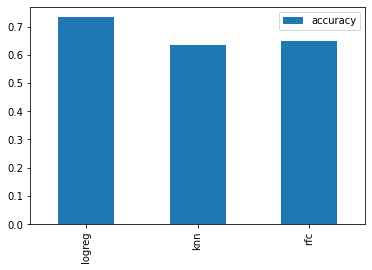

In [14]:
# Plot scores for comparison
models = pd.DataFrame(model_scores, index = ["accuracy"])
models.T.plot.bar();

## Run Randomized Cross Validation
Running a randomized cross validation on the top two models: logistic regression and random forest classifier.
Tuning models: Define a search space as a bounded domain of hyperparameter values and randomly sample points in that domain.

In [15]:
#Randomized CV
LR_grid = {"C": np.logspace(-4, 4, 20),
           "solver": ["liblinear"]}

RF_grid = {"n_estimators" : [100,500,2000],
          "max_depth": [3, 10, 20, 30],
          "min_samples_split": np.arange(2, 8, 2),
          "min_samples_leaf": np.arange(1, 6, 2)}

np.random.seed(68)
LR = RandomizedSearchCV(LogisticRegression(),
                           param_distributions = LR_grid,
                           cv =10,
                           n_iter = 20)

RF = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions = RF_grid,
                           cv =10,
                           n_iter = 20)

print('Best logistiic regression params: ',LR.fit(X_train, y_train).best_params_)
print('Best random forest params: ',RF.fit(X_train, y_train).best_params_)


Best logistiic regression params:  {'solver': 'liblinear', 'C': 1.623776739188721}
Best random forest params:  {'n_estimators': 500, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 30}


In [16]:
# Test score
print('Random Forest ',RF.score(X_test, y_test))
print('Logistic Regression ', LR.score(X_test, y_test))

Random Forest  0.7
Logistic Regression  0.7333333333333333


### Logistic Regression Prediction and Metrics

Since logistic regression gave the best model, we will focus only on those metrics below.

In [17]:
#Predict
y_pred_LR= LR.predict(X_test)


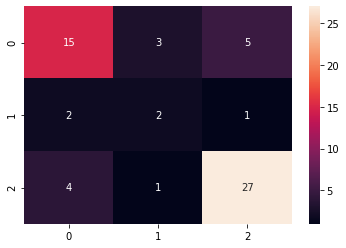

In [18]:
# Confusion matrix for logistic regression
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_pred_LR, y_test)
sns.heatmap(matrix, annot=True)
plt.show()

In [19]:
# Classification report for logistic regression
print(classification_report(y_test, y_pred_LR))

              precision    recall  f1-score   support

         0.0       0.65      0.71      0.68        21
         1.0       0.40      0.33      0.36         6
         2.0       0.84      0.82      0.83        33

    accuracy                           0.73        60
   macro avg       0.63      0.62      0.63        60
weighted avg       0.73      0.73      0.73        60



### Summary:
 Here, a tuned logistic regression model suited our data best out of the three models tested. 